## Общей задачей является обучение модели детектировать наличие QRS комплекса в сигнале ЭКГ.
__В процессе решения будет создан бинарный классификатор, который по небольшой области размером в 200 временных отчетов (вырезанной части исходного сигнала) научится определять, имеется ли по центру участка QRS пик.
В качестве ML модели будет использоваться градиентный бустинг.__<br>
>То есть на вход классификатора будет подаваться маленькая область сигнала, а на выходе мы говорить, находиться ли по центру этой области его QRS комплекс или нет. Тем самым создадим бинарную классификацию 1 - есть, 0 - нет.

Обучение будет происходить по данным ЭКГ сигналов большого числа пациентов. Датасет сигналов электрокардиограммы для обучения и тестирования будет взят с MIT-BIH Database.<br>

_Для итогового определения QRS комплеса на неизвестном сигнале будет использоваться подход со скольжением небольшого окна по сигналу и последующей классификацией каждой области на наличие пика с помощью заранее обученной модели._

In [1323]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import os
from scipy.signal import find_peaks
from sklearn.model_selection import train_test_split
from catboost import CatBoost
from matplotlib.pyplot import figure
from sklearn import datasets
from catboost.utils import eval_metric
import random
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [1324]:
#pip install catboost

Прочтем из архива, который скачали по ссылке https://www.kaggle.com/datasets/mondejar/mitbih-database?resource=download&select=100.csv все файлы и выберем те, что являются csv

In [1325]:
list_files = os.listdir('D:\Python_notebooks\project_files\ECG')
list_csv = []
for name in list_files:
    if '.csv' in name:
        list_csv.append(name)
print(', '.join(list_csv))

100.csv, 101.csv, 102.csv, 103.csv, 104.csv, 105.csv, 106.csv, 107.csv, 108.csv, 109.csv, 111.csv, 112.csv, 113.csv, 114.csv, 115.csv, 116.csv, 117.csv, 118.csv, 119.csv, 121.csv, 122.csv, 123.csv, 124.csv, 200.csv, 201.csv, 202.csv, 203.csv, 205.csv, 207.csv, 208.csv, 209.csv, 210.csv, 212.csv, 213.csv, 214.csv, 215.csv, 217.csv, 219.csv, 220.csv, 221.csv, 222.csv, 223.csv, 228.csv, 230.csv, 231.csv, 232.csv, 233.csv, 234.csv


In [1326]:
len(list_csv)

48

Таким образом, у нас есть 48 разных пациентов и их результаты записи ЭКГ. Возьмем на train все области сигнала с QRS по центру данной области для 46 первых пациентов, а тестироваться будем на участках сигнала последних двух пациентов (233.csv и 234.csv)

In [1327]:
path = 'D:\Python_notebooks\project_files\ECG/'
list_train = list_csv[:-2]
list_test = list_csv[46:]
len(list_train)

46

In [1328]:
list_test

['233.csv', '234.csv']

Приступим подготавливать тренировочную выборку: <br/>
Для поиска QRS будем использовать find_peaks модуль.
<br/>Рассмотрим на примере 100.csv как происходит подготовка данных для обучения и теста а потом реализуем всю подготовку в одном большом цикле.


In [1329]:
data = pd.read_csv('D:\Python_notebooks\project_files\ECG/100.csv')
columns = data.columns

650000


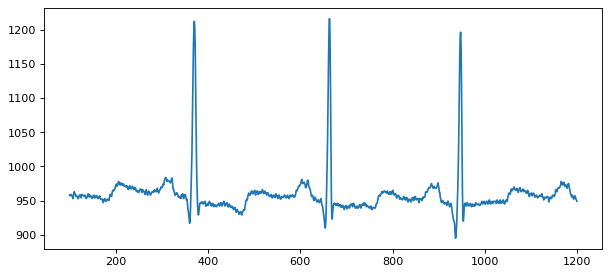

In [1330]:
signal = data[columns[1]]
print(len(signal))
signal = signal[0:25000]
figure(figsize=(9, 4), dpi=80);
plt.plot(signal[100:1200]);

Координаты пиков: [   77   370   663   947  1231  1515  1809  2045  2403  2706  2998  3283
  3560  3863  4171  4466  4765  5061  5347  5634  5918  6215  6527  6824
  7106  7393  7670  7953  8246  8539  8837  9142  9432  9710  9998 10283
 10591 10895 11191 11480 11781 12066 12351 12645 12950 13267 13562 13842
 14131 14423 14711 15012 15310 15607 15900 16183 16465 16755 17058 17359
 17657 17947 18227 18514 18796 19081 19389 19694 19989 20272 20554 20838
 21131 21424 21729 22030 22321 22603 22881 23164 23454 23757 24053 24346
 24626 24914]


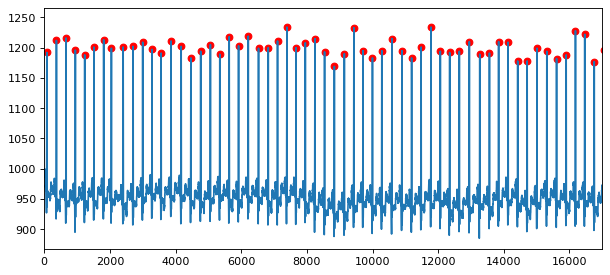

In [1331]:
peaks = find_peaks(signal, distance=200)
print('Координаты пиков:',peaks[0])
figure(figsize=(9, 4), dpi=80);
plt.plot(signal)
plt.scatter(peaks[0], signal[peaks[0]], color='red')
plt.xlim([0, 17000]);

In [1332]:
window = 200  # Размер окна наблюдения
dataset = []
for i in range(0, len(signal)-window, 12):
    piece = signal[i:i+window] / np.max(np.abs(signal[i:i+window])) 
    piece = piece - np.mean(piece)  # нормолизация как деление на максимум а далее отнимание среднего
    is_peak = 0
    middle = (i + i + window) / 2
    for peak in peaks[0]:
        if peak >= middle - 20 and peak < middle + 20:
            is_peak = 1
            break
    piece = np.append(piece, is_peak)
    dataset.append(piece)

In [1333]:
df = pd.DataFrame(dataset)
df.tail()

,0,1,2,3,4,5,6,7,8,9,...,191,192,193,194,195,196,197,198,199,200
2062,-0.007784,-0.006182,-0.005381,-0.003778,-0.005381,-0.007784,-0.006182,-0.005381,-0.004579,-0.002175,...,-0.020605,-0.019804,-0.019804,-0.019002,-0.019804,-0.020605,-0.023009,-0.022208,-0.021406,0.0
2063,-0.002969,-0.004571,-0.002969,-0.003770,-0.001366,-0.005373,-0.005373,-0.003770,-0.001366,-0.001366,...,-0.020597,-0.018994,-0.018193,-0.014988,-0.018193,-0.016591,-0.019796,-0.018994,-0.018994,0.0
2064,-0.004483,-0.002881,-0.002079,-0.004483,-0.003682,-0.006887,-0.005284,-0.006887,-0.006086,-0.004483,...,-0.020509,-0.019708,-0.018105,-0.014900,-0.014900,-0.016502,-0.017304,-0.019708,-0.018105,0.0
2065,-0.006114,-0.008518,-0.007716,-0.005313,-0.006114,-0.007716,-0.006114,-0.006114,-0.006114,-0.006114,...,-0.019736,-0.018934,-0.017332,-0.014928,-0.017332,-0.016530,-0.018133,-0.017332,-0.016530,0.0
2066,-0.008710,-0.006306,-0.005505,-0.006306,-0.007909,-0.008710,-0.008710,-0.007909,-0.006306,-0.006306,...,-0.015921,-0.017524,-0.016723,-0.015921,-0.015921,-0.016723,-0.018325,-0.017524,-0.015921,0.0


Для одного лишь пациента получается такой большой датафрейм с данными, состоящий из двухсот значений сигнала и результата в столбце под номером 200, где указано 1 если это область содержит QRS по центру и 0 есть нет

In [1334]:
df[200].value_counts() # выдаст сколько элементов содержат пики а сколько нет

0.0    1784
1.0     283
Name: 200, dtype: int64

У нас слишком непропорциональное число 1 и 0 классов, так что сделаем чтобы соотношение 0 и 1 стало примерно 50 на 50
Для этого рандомно удалим часть строк из датафрема где стоят 0 как разультат классификации

In [1335]:
df['ind'] = range(df.shape[0])
index_class0 = df[df[200]==0]['ind']
index_class1 = df[df[200]==1]['ind']
index_class0_downsampled = np.random.choice(index_class0, size=df[df[200]==1].shape[0], replace=False)

In [1336]:
index_class0.shape

(1784,)

In [1337]:
index_class0_downsampled.shape

(283,)

In [1338]:
index_class1.shape[0]

283

In [1339]:
connected_01 =list(index_class0_downsampled) + list(index_class1)
print(len(connected_01))
df_new = df.query("ind in @connected_01")
df_new = df_new.drop('ind', axis=1)
df_new = df_new.reset_index()
df_new = df_new.drop('index', axis=1)

566


In [1340]:
df_new.head()

,0,1,2,3,4,5,6,7,8,9,...,191,192,193,194,195,196,197,198,199,200
0,-0.005346,-0.003311,0.000758,-0.002294,-0.002294,-0.004329,-0.006363,-0.005346,-0.006363,-0.007380,...,0.006862,0.006862,0.007879,0.011948,0.011948,0.010931,0.017035,0.018052,0.021104,0.0
1,-0.009355,-0.007322,-0.007322,-0.007322,-0.010371,-0.011387,-0.011387,-0.009355,-0.009355,-0.007322,...,-0.011387,-0.008338,-0.006306,-0.005290,-0.006306,-0.010371,-0.013420,-0.012403,-0.016468,0.0
2,0.000223,0.001873,0.001873,0.001048,0.000223,-0.002252,0.001048,0.000223,-0.000602,-0.001427,...,-0.019579,-0.019579,-0.017104,-0.016279,-0.017929,-0.019579,-0.020404,-0.020404,-0.018754,1.0
3,-0.000924,0.000726,0.002376,-0.000924,-0.003399,-0.004224,-0.001749,0.000726,-0.000099,-0.000924,...,-0.021551,-0.020726,-0.020726,-0.019076,-0.020726,-0.024026,-0.024851,-0.024026,-0.021551,1.0
4,-0.001955,-0.000305,0.000520,0.001345,0.001345,0.000520,0.002170,0.001345,0.003820,0.002170,...,-0.025883,-0.024233,-0.023408,-0.022583,-0.023408,-0.025883,-0.026708,-0.024233,-0.022583,1.0


Теперь классы сбалансированы для одного пациента



In [1341]:
df_new[200].value_counts()

0.0    283
1.0    283
Name: 200, dtype: int64

Посмотрим как выглядят данные маленькие части сигналов которые мы классифицировали как 1 или 0:

#### Примеры фрагментов с классом 0 (QRS отсутвует в центральной области диапазона)

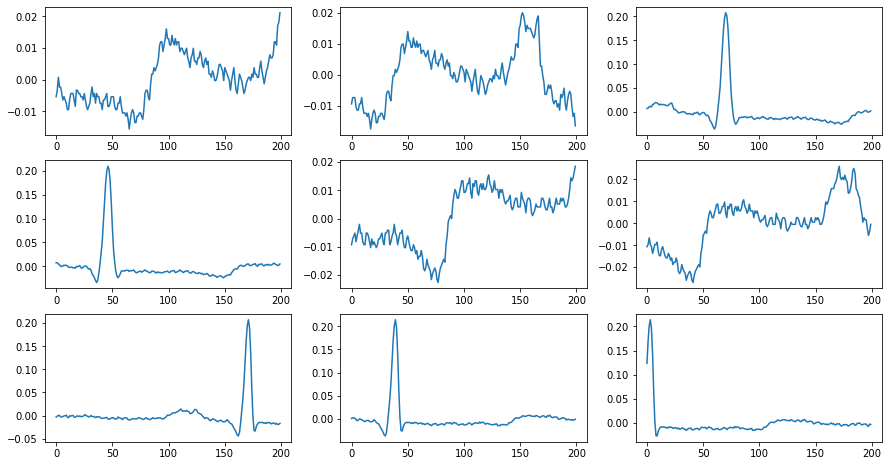

In [1342]:
fig, axes = plt.subplots(3, 3, figsize=(15,8))
for i, ax in enumerate(axes.flatten()):
    ax.plot(df_new[df_new[200]==0].iloc[i , :200])
plt.show()

#### Примеры фрагментов с классом 1 (QRS присутствует в центральной области диапазона)

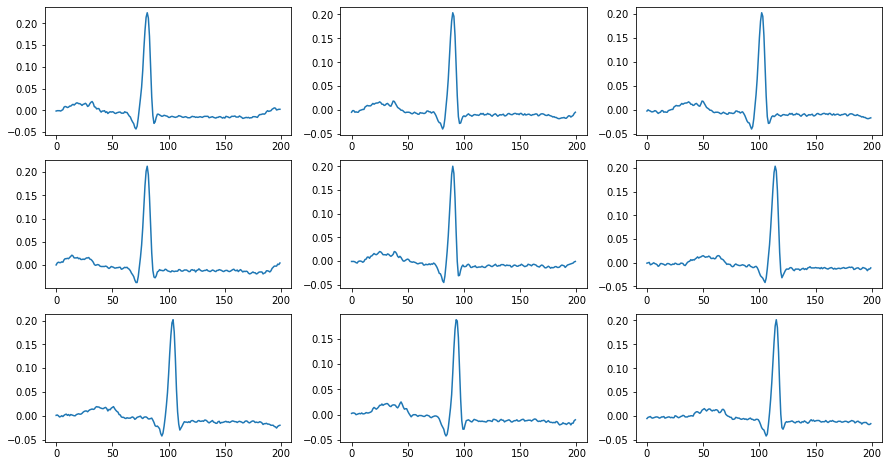

In [1343]:
fig, axes = plt.subplots(3, 3, figsize=(15,8))
for i, ax in enumerate(axes.flatten()):
    ax.plot(df_new[df_new[200]==1].iloc[random.randint(0, index_class1.shape[0]-1) , :200])
plt.show()

 __Все что было написано выше было лишь демонстрацией и пояснением к работе моего кода. Но прошлый фрагмент был адресован лишь к одному пациенту. Так что теперь в цикле проделаем эти же преобразования и для других пациентов и конкатиноруем их результаты такого цикла в общий трейновый датасет. А так же создадим отдельно тестовый датасет по такому же правилу.__

In [1344]:
def preparation (list_csv, path, dist):
    df_merged = pd.DataFrame()
    for name in list_csv:
        data = pd.read_csv(path+name)
        columns = data.columns
        signal = data[columns[1]]
        signal = signal[0:25000]
        peaks = find_peaks(signal, distance=dist[name])
        window = 200  # Размер окна наблюдения
        dataset = []
        for i in range(0, len(signal)-window, 2):
            piece = signal[i:i+window] / np.max(np.abs(signal[i:i+window])) 
            piece = piece - np.mean(piece)  # нормолизация как деление на максимум а далее отнимание среднего
            is_peak = 0
            middle = (i + i + window) / 2
            for peak in peaks[0]:
                if peak >= middle - 5 and peak < middle + 5:
                    is_peak = 1
                    break
            piece = np.append(piece, is_peak)
            dataset.append(piece)        
        df = pd.DataFrame(dataset)
        df['ind'] = range(df.shape[0])
        index_class0 = df[df[200]==0]['ind']
        index_class1 = df[df[200]==1]['ind']
        index_class0_downsampled = np.random.choice(index_class0, size=df[df[200]==1].shape[0], replace=False)
        connected_01 =list(index_class0_downsampled) + list(index_class1)
        df_new = df.query("ind in @connected_01")
        df_new = df_new.drop('ind', axis=1)
        df_new = df_new.reset_index()
        df_new = df_new.drop('index', axis=1)        
        df_merged = df_merged.append(df_new, ignore_index=True)
    return df_merged

Значение дистанции на самом деле различно для каждого из сигналов, ведь частота сердцебиения у каждого человека может быть различной. Убедимся, что для всех dist = 200 не лучший вариант. 

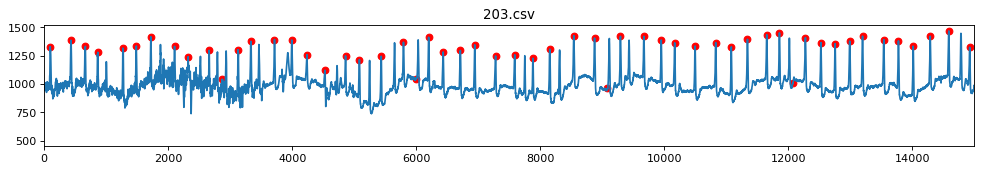

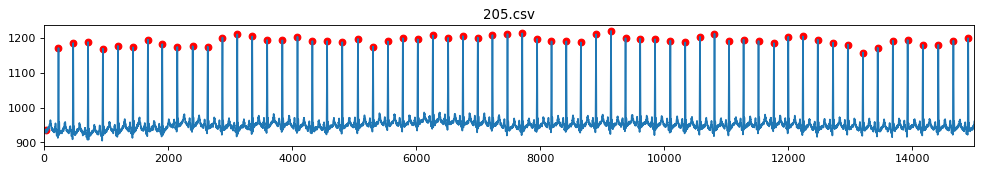

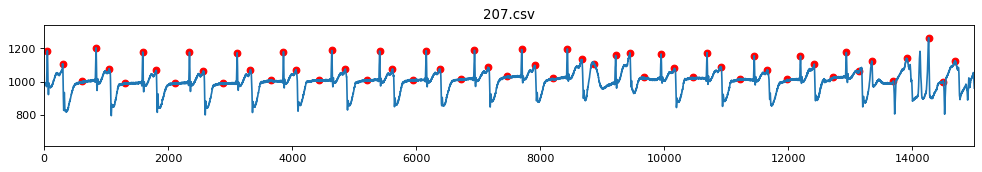

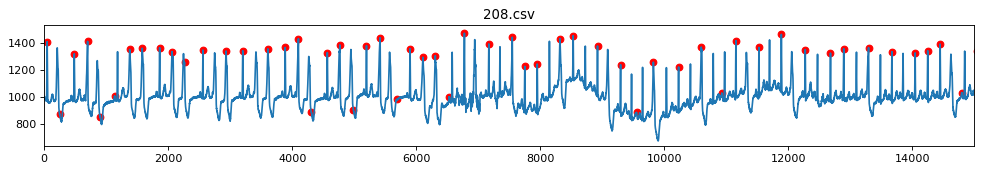

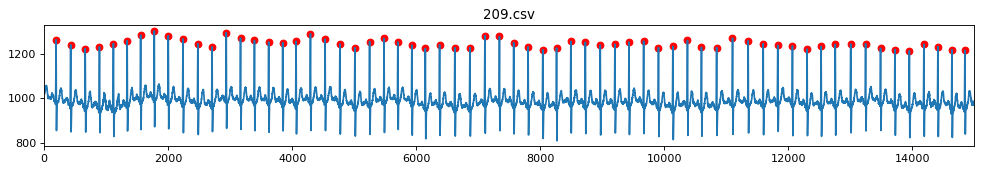

In [1345]:
for name in list_train[-20:-15]:
        data = pd.read_csv(path+name)
        columns = data.columns
        signal = data[columns[1]]
        signal = signal[0:25000]
        peaks = find_peaks(signal, distance=200)
        figure(figsize=(15, 2), dpi=80);
        plt.plot(signal)
        plt.title(name)
        plt.scatter(peaks[0], signal[peaks[0]], color='red')
        plt.xlim([0, 15000]);

Я руками провел исследование и нашел для каждого csv свой подходящий параметр dist. Так что задам его в виде словарика где ключами будет выступать имена сsv

In [1346]:
numbers = list(200*np.ones(len(list_train)))
dist = dict(zip(list_train, numbers))
dist['114.csv'] = 230
dist['117.csv'] = 230
dist['119.csv'] = 300
dist['123.csv'] = 300
dist['124.csv'] = 300
dist['202.csv'] = 300
dist['207.csv'] = 500
dist['208.csv'] = 150
dist['215.csv'] = 150
dist

{'100.csv': 200.0,
 '101.csv': 200.0,
 '102.csv': 200.0,
 '103.csv': 200.0,
 '104.csv': 200.0,
 '105.csv': 200.0,
 '106.csv': 200.0,
 '107.csv': 200.0,
 '108.csv': 200.0,
 '109.csv': 200.0,
 '111.csv': 200.0,
 '112.csv': 200.0,
 '113.csv': 200.0,
 '114.csv': 230,
 '115.csv': 200.0,
 '116.csv': 200.0,
 '117.csv': 230,
 '118.csv': 200.0,
 '119.csv': 300,
 '121.csv': 200.0,
 '122.csv': 200.0,
 '123.csv': 300,
 '124.csv': 300,
 '200.csv': 200.0,
 '201.csv': 200.0,
 '202.csv': 300,
 '203.csv': 200.0,
 '205.csv': 200.0,
 '207.csv': 500,
 '208.csv': 150,
 '209.csv': 200.0,
 '210.csv': 200.0,
 '212.csv': 200.0,
 '213.csv': 200.0,
 '214.csv': 200.0,
 '215.csv': 150,
 '217.csv': 200.0,
 '219.csv': 200.0,
 '220.csv': 200.0,
 '221.csv': 200.0,
 '222.csv': 200.0,
 '223.csv': 200.0,
 '228.csv': 200.0,
 '230.csv': 200.0,
 '231.csv': 200.0,
 '232.csv': 200.0}

In [1347]:
df_train = preparation(list_train, path, dist)

In [1348]:
list_test

['233.csv', '234.csv']

Значение дистанции на самом деле различно для каждого из сигналов, ведь частота сердцебиения у каждого человека может быть различной. Экспериментально убедимся, что при условии dist=150 для test очень даже неплохие результаты

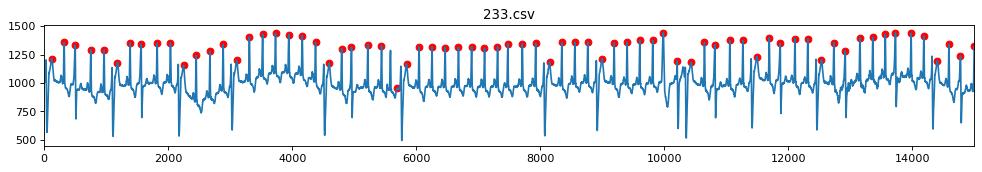

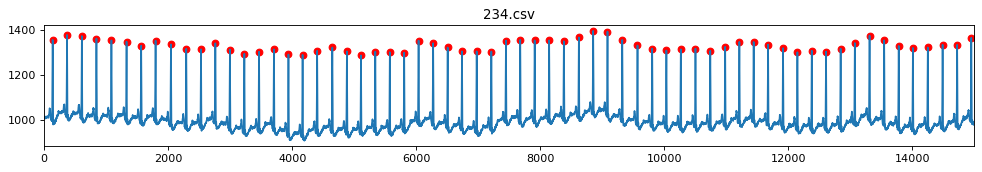

In [1349]:
for name in list_test:
        data = pd.read_csv(path+name)
        columns = data.columns
        signal = data[columns[1]]
        signal = signal[0:25000]
        peaks = find_peaks(signal, distance=150)
        figure(figsize=(15, 2), dpi=80)
        plt.plot(signal)
        plt.title(name)
        plt.scatter(peaks[0], signal[peaks[0]], color='red')
        plt.xlim([0, 15000])
        plt.show()

In [1350]:
numbers = list(150*np.ones(len(list_test)))
dist = dict(zip(list_test, numbers))

In [1351]:
df_test = preparation(list_test, path, dist)

In [1352]:
df_train[200].value_counts()

0.0    19556
1.0    19556
Name: 200, dtype: int64

In [1353]:
df_test[200].value_counts()

1.0    1130
0.0    1130
Name: 200, dtype: int64

Теперь данные на train и test готовы, так что посмотрим, что из себя представляют пики QRS по центру для различных рандомно выбранных данных из train датафрейма (__то есть класс 1__)

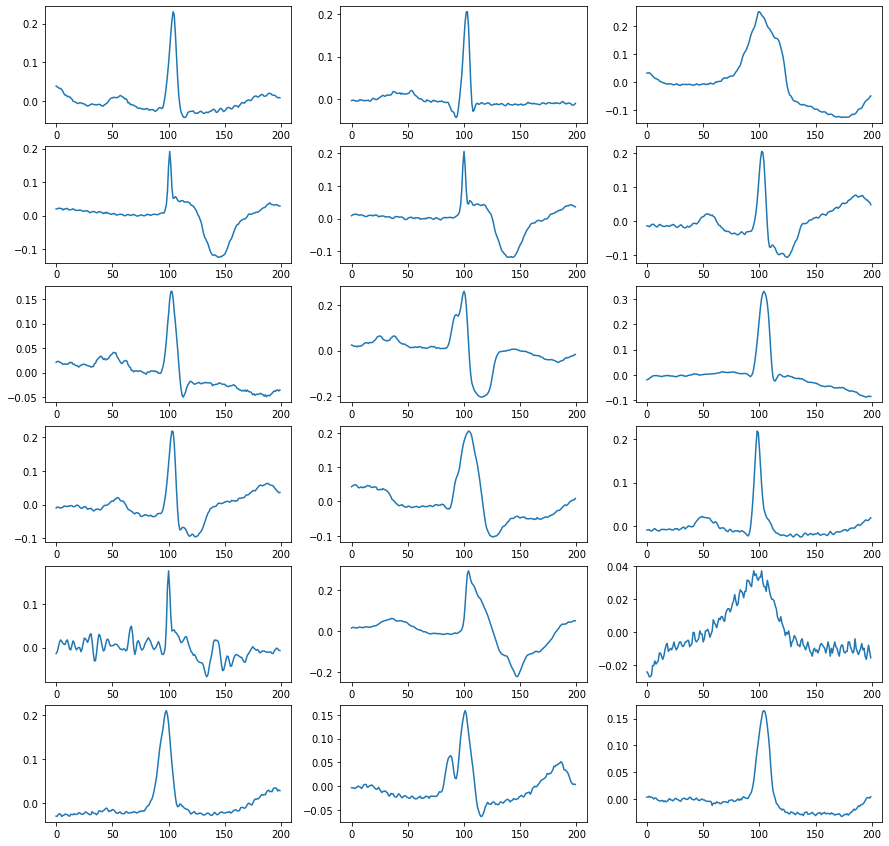

In [1354]:
fig, axes = plt.subplots(6, 3, figsize=(15,15))
for i, ax in enumerate(axes.flatten()):
    ax.plot(df_train[df_train[200]==1].iloc[random.randint(0, df_train[df_train[200]==1].shape[0]-1) , :200])
plt.show()

Посмотрим, что из себя представляют фрагменты сигнала, в которых по центру отсутвует QRS комплекс (__то есть класс 0__)

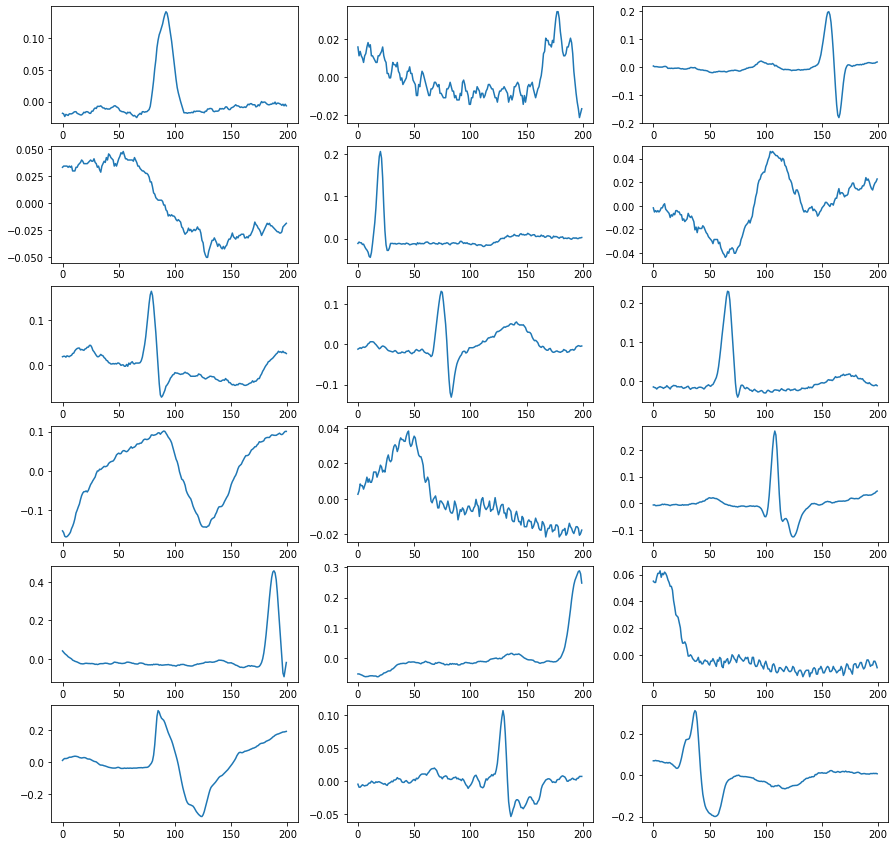

In [1355]:
fig, axes = plt.subplots(6, 3, figsize=(15,15))
for i, ax in enumerate(axes.flatten()):
    ax.plot(df_train[df_train[200]==0].iloc[random.randint(0, df_train[df_train[200]==0].shape[0]-1) , :200])
plt.show()

### Обучение градиентного бустинга (CatBoost)

In [1356]:
X_train = df_train.iloc[: , :200]
Y_train = df_train[200]
X_test = df_test.iloc[: , :200]
Y_test = df_test[200]

In [1357]:
X_train.shape

(39112, 200)

In [1358]:
Y_train.shape

(39112,)

In [1359]:
X_test.shape

(2260, 200)

In [1360]:
Y_test.shape

(2260,)

In [1361]:
booster = CatBoost(params={'iterations':100, 'loss_function':'Logloss'})

booster.fit(X_train, Y_train, eval_set=(X_test, Y_test))
booster.set_feature_names([str(i) for i in range(200)])

test_preds = booster.predict(X_test, prediction_type="Class")
train_preds = booster.predict(X_train, prediction_type="Class")

Learning rate set to 0.213407
0:	learn: 0.4445117	test: 0.4273911	best: 0.4273911 (0)	total: 31.5ms	remaining: 3.12s
1:	learn: 0.3104960	test: 0.2867001	best: 0.2867001 (1)	total: 60.4ms	remaining: 2.96s
2:	learn: 0.2450944	test: 0.2182075	best: 0.2182075 (2)	total: 90.6ms	remaining: 2.93s
3:	learn: 0.2092418	test: 0.1784202	best: 0.1784202 (3)	total: 120ms	remaining: 2.87s
4:	learn: 0.1891188	test: 0.1550844	best: 0.1550844 (4)	total: 148ms	remaining: 2.81s
5:	learn: 0.1697562	test: 0.1354197	best: 0.1354197 (5)	total: 177ms	remaining: 2.77s
6:	learn: 0.1586818	test: 0.1235489	best: 0.1235489 (6)	total: 207ms	remaining: 2.75s
7:	learn: 0.1500465	test: 0.1135918	best: 0.1135918 (7)	total: 237ms	remaining: 2.72s
8:	learn: 0.1439295	test: 0.1102099	best: 0.1102099 (8)	total: 266ms	remaining: 2.69s
9:	learn: 0.1381523	test: 0.0990987	best: 0.0990987 (9)	total: 294ms	remaining: 2.64s
10:	learn: 0.1347390	test: 0.0938540	best: 0.0938540 (10)	total: 321ms	remaining: 2.6s
11:	learn: 0.1312199

bestIteration = 92

Shrink model to first 93 iterations.


In [1362]:
print("\nTest  Accuracy : %f"%eval_metric(Y_test.values, test_preds, "Accuracy")[0])
print("Train Accuracy : %f"%eval_metric(Y_train.values, train_preds, "Accuracy")[0])


Test  Accuracy : 0.980531
Train Accuracy : 0.979955


Матрица несоответствий ":



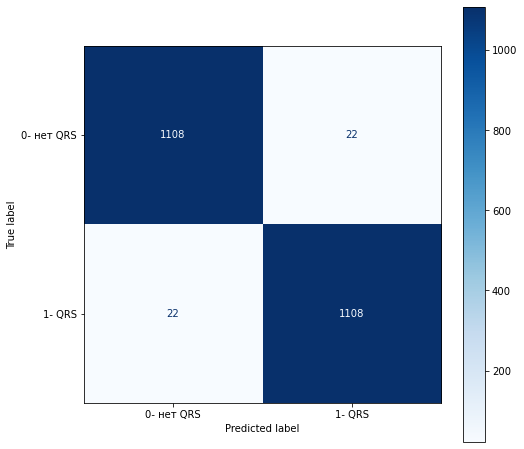

In [1363]:
names = ['0- нет QRS', '1- QRS']
fig, ax = plt.subplots(figsize=(8, 8))
print('Матрица несоответствий ":\n')
disp = ConfusionMatrixDisplay(confusion_matrix(Y_test.values, test_preds), display_labels = names)
disp.plot(cmap = 'Blues', ax=ax);

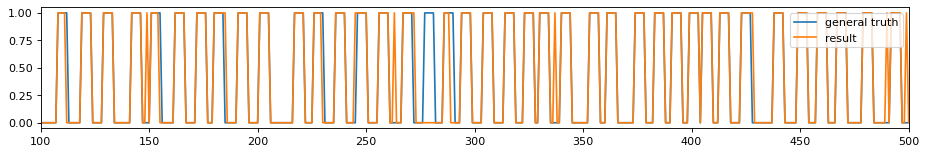

In [1364]:
figure(figsize=(14, 2), dpi=80)
plt.plot(Y_test.values, label='general truth')
plt.plot(test_preds, label='result')
plt.xlim([100, 500])
plt.legend();

Посмотрим, а где же он именоо ошибается:
    

In [1365]:
# False negative
fn = []
for i in range(len(Y_test.values)):
    if (Y_test.values[i] == 1) & (test_preds[i] == 0):
        fn.append(str(i))
print(', '.join(fn))

50, 112, 155, 230, 277, 278, 279, 280, 281, 289, 290, 555, 578, 771, 772, 773, 774, 775, 783, 842, 1134, 1151


In [1366]:
# False Positive
fp = []
for i in range(len(Y_test.values)):
    if (Y_test.values[i] == 0) & (test_preds[i] == 1):
        fp.append(str(i))
print(', '.join(fp))

63, 149, 185, 245, 263, 272, 337, 428, 490, 499, 664, 695, 931, 1068, 1092, 1093, 1310, 1391, 1463, 1871, 1925, 2115


#### На самом деле класс 1, но классификатор отнес к 0:

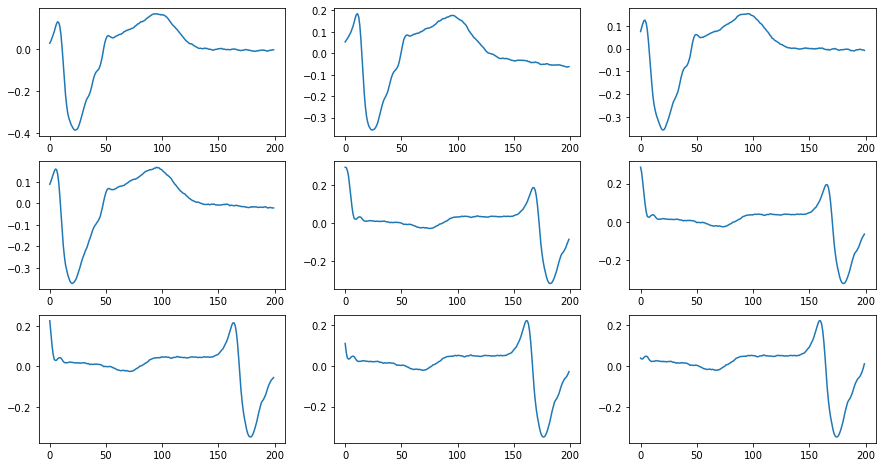

In [1367]:
fig, axes = plt.subplots(3, 3, figsize=(15,8))
for i, ax in enumerate(axes.flatten()):
    ax.plot(df_test.iloc[int(fn[i]) , :200])
plt.show()

#### На самом деле класс 0, но классификатор отнес к 1:

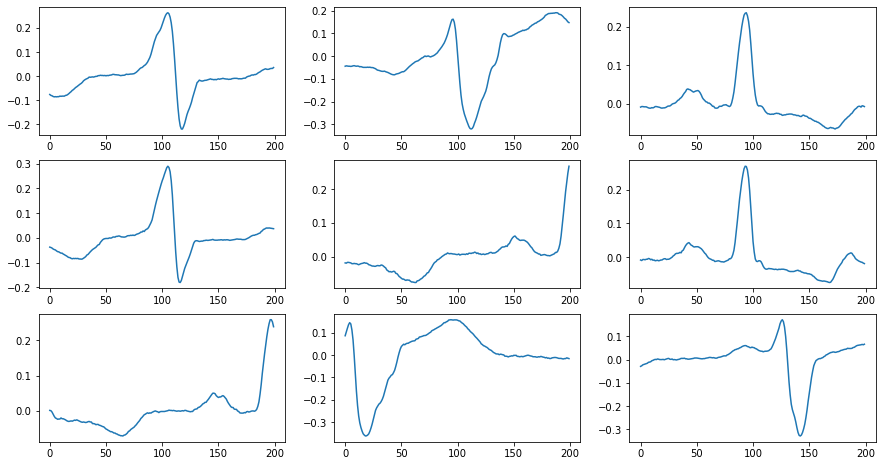

In [1368]:
fig, axes = plt.subplots(3, 3, figsize=(15,8))
for i, ax in enumerate(axes.flatten()):
    ax.plot(df_test.iloc[int(fp[i]) , :200])
plt.show()

Как видно некотороые такие ошибки скорее связаны с ошибками в работе пикового детектора, который и заложен в проверке качества тестового предсказания

__Попробуем воспользоваться обученным классификатором и применим его немного для другой задачи. Теперь будем на незнакомом тестовом сигнале находить места пиков.__

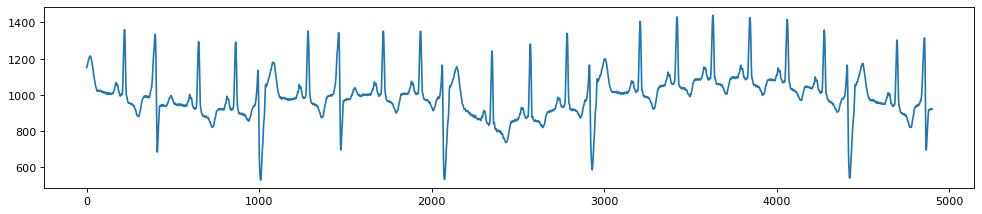

In [1369]:
data_check = pd.read_csv('D:\Python_notebooks\project_files\ECG/233.csv')
signal_check = data_check[columns[1]].values
figure(figsize=(15, 3), dpi=80)
signal_check = signal_check[0:50000]
plt.plot(signal_check[100:5000]);

In [1370]:
window = 200
dataset_check = []
middles = []
for i in range(0, len(signal_check)-window, 6):
    piece = signal_check[i:i+window] / np.max(np.abs(signal_check[i:i+window]))
    piece = piece - np.mean(piece)
    is_peak = 0
    middle = (i + i + window) / 2
    middles.append(middle)
    dataset_check.append(piece)

In [1371]:
df_check = pd.DataFrame(dataset_check)
test_preds = booster.predict(df_check, prediction_type="Class")

In [1372]:
df_check.head()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,-0.017941,-0.017941,-0.017941,-0.017941,-0.017941,-0.017941,-0.017941,-0.017941,-0.017941,-0.017117,...,-0.009703,-0.010527,-0.007232,-0.007232,-0.006409,-0.008056,-0.010527,-0.011351,-0.012175,-0.013822
1,-0.018151,-0.018151,-0.018151,-0.017327,-0.016503,-0.014032,-0.012385,-0.009090,-0.007442,-0.004971,...,-0.010737,-0.011561,-0.012385,-0.014032,-0.014032,-0.013208,-0.011561,-0.009914,-0.009090,-0.009090
2,-0.012500,-0.009205,-0.007558,-0.005086,-0.000968,0.006446,0.013035,0.022096,0.032805,0.045161,...,-0.011676,-0.010029,-0.009205,-0.009205,-0.010853,-0.011676,-0.012500,-0.013324,-0.015795,-0.015795
3,0.013336,0.022397,0.033105,0.045461,0.057817,0.070997,0.087471,0.103122,0.122068,0.137718,...,-0.012199,-0.013023,-0.015494,-0.015494,-0.014671,-0.017965,-0.016318,-0.013847,-0.013023,-0.011376
4,0.089160,0.104811,0.123756,0.139407,0.146820,0.143526,0.122109,0.080099,0.020791,-0.054168,...,-0.014629,-0.012158,-0.011334,-0.009687,-0.010511,-0.012982,-0.012982,-0.016277,-0.014629,-0.017100


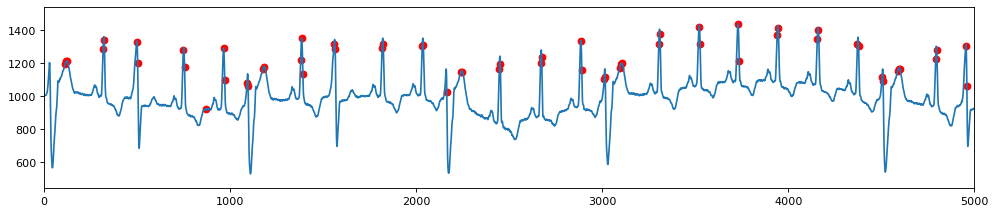

In [1373]:
peaks = np.where(test_preds>0)[0]
middles = np.asarray(middles)
figure(figsize=(15, 3), dpi=80)
plt.plot(signal_check)
plt.scatter(middles[peaks], [list(signal_check)[x] for x in list((middles[peaks]).astype(np.int64))], color='red')
plt.xlim([0, 5000]);

Рассмотрим еще один тестовой сигнал (на нем не обучались):

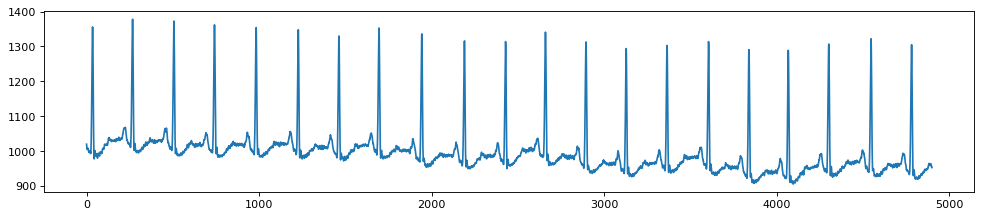

In [1374]:
data_check = pd.read_csv('D:\Python_notebooks\project_files\ECG/234.csv')
signal_check = data_check[columns[1]].values
figure(figsize=(15, 3), dpi=80)
signal_check = signal_check[0:50000]
plt.plot(signal_check[100:5000]);

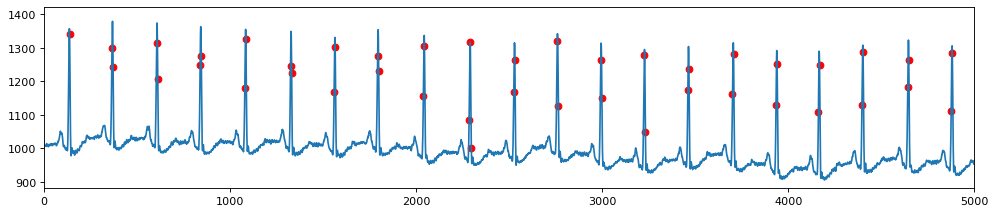

In [1375]:
window = 200
dataset_check = []
middles = []
for i in range(0, len(signal_check)-window, 6):
    piece = signal_check[i:i+window] / np.max(np.abs(signal_check[i:i+window]))
    piece = piece - np.mean(piece)
    is_peak = 0
    middle = (i + i + window) / 2
    middles.append(middle)
    dataset_check.append(piece)
df_check = pd.DataFrame(dataset_check)
test_preds = booster.predict(df_check, prediction_type="Class")
peaks = np.where(test_preds>0)[0]
middles = np.asarray(middles)
figure(figsize=(15, 3), dpi=80)
plt.plot(signal_check)
plt.scatter(middles[peaks], [list(signal_check)[x] for x in list((middles[peaks]).astype(np.int64))], color='red')
plt.xlim([0, 5000]);

Тем самым мы смогли на незнакомом сигнале без очевидного заранее известного периода седцебиения довольно точно детектировать области QRS комплекса.

Тем самым мы можем на любом сигнале ЭКГ с любой частотой серцебиения находить места QRS комплексов, что в случае пикового детектирования делать сложно, ведь для пикового детектирования всегда надо знать оптимальное значение размера окна, которое определяется частотой колебания сердца